In [1]:
import clean_datasets as mydata


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [2]:
credit = mydata.load_data(mydata.CREDIT_COLS, mydata.CREDIT_NAME)
pipeline = mydata.get_credit_pipeline()

data/crx.data


In [3]:
label_binalizer = LabelBinarizer()
X = pipeline.fit_transform(credit)
y = label_binalizer.fit_transform(credit['A16'])

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    strat_train_set = X[train_index], y[train_index]
    strat_test_set = X[test_index], y[test_index]

In [5]:
Xtr, Ytr = strat_train_set
Xts, Yts = strat_test_set

In [6]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = DecisionTreeClassifier()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {"max_depth": range(1, 20, 2),
              "max_features": range(1, 30, 2),
              "min_samples_split": range(2, 20, 2),
              "criterion": ["gini", "entropy"]
             }

# run grid search
decision_tree_grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False, return_train_score=True)
start = time()
decision_tree_grid_search.fit(Xtr, Ytr)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(decision_tree_grid_search.cv_results_['params'])))
report(decision_tree_grid_search.cv_results_)

GridSearchCV took 41.94 seconds for 2700 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.879 (std: 0.023)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 19, 'min_samples_split': 12}

Model with rank: 2
Mean validation score: 0.875 (std: 0.028)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 15, 'min_samples_split': 12}

Model with rank: 3
Mean validation score: 0.873 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 17, 'min_samples_split': 6}



In [7]:
print(decision_tree_grid_search.best_params_,  decision_tree_grid_search.best_score_)
best_dec_tree = decision_tree_grid_search.best_estimator_

Ypr = best_dec_tree.predict(Xts)
Ypr = (Ypr > 0.5)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

{'criterion': 'gini', 'max_depth': 7, 'max_features': 19, 'min_samples_split': 12} 0.8786363636363635
Accuracy is  76.81159420289855


# Neural Networks


In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [10]:
#We create training and validation folds
Xval, Xtra = Xtr[:50].copy(), Xtr[50:].copy()
Yval, Ytra = Ytr[:50].copy(), Ytr[50:].copy()

Xval.shape

(50, 51)

In [11]:
def build_model(n_hidden=1, n_neurons=8, learning_rate=3e-3, input_dim=51):
    model = keras.models.Sequential()
    options = {"input_dim": input_dim}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss="binary_crossentropy", 
                  optimizer=optimizer, 
                  metrics = ["accuracy"])
    return model 

In [12]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [13]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 50),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_class, 
                                   param_distribs, 
                                   n_iter=20, 
                                   cv=3)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

rnd_search_cv.fit(Xtra, 
                  Ytra, 
                  epochs=50,
                  batch_size = 24,
                  validation_data=(Xval, Yval),
                  callbacks=[early_stopping_cb])

Train on 334 samples, validate on 50 samples
Epoch 1/50
334/334 [==============================] - 10s 30ms/step - loss: 0.7825 - acc: 0.4251 - val_loss: 0.7344 - val_acc: 0.4600
Epoch 2/50
334/334 [==============================] - 0s 275us/step - loss: 0.7489 - acc: 0.3892 - val_loss: 0.7135 - val_acc: 0.4400
Epoch 3/50
334/334 [==============================] - 0s 337us/step - loss: 0.7263 - acc: 0.4042 - val_loss: 0.6957 - val_acc: 0.4600
Epoch 4/50
334/334 [==============================] - 0s 312us/step - loss: 0.7102 - acc: 0.4401 - val_loss: 0.6841 - val_acc: 0.4600
Epoch 5/50
334/334 [==============================] - 0s 263us/step - loss: 0.6984 - acc: 0.4850 - val_loss: 0.6777 - val_acc: 0.4600
Epoch 6/50
334/334 [==============================] - 0s 268us/step - loss: 0.6886 - acc: 0.5180 - val_loss: 0.6729 - val_acc: 0.5000
Epoch 7/50
334/334 [==============================] - 0s 269us/step - loss: 0.6812 - acc: 0.5719 - val_loss: 0.6683 - val_acc: 0.6000
Epoch 8/50
334/33

335/335 [==============================] - 0s 256us/step - loss: 0.5670 - acc: 0.8090 - val_loss: 0.5369 - val_acc: 0.8400
Epoch 19/50
335/335 [==============================] - 0s 262us/step - loss: 0.5614 - acc: 0.8179 - val_loss: 0.5312 - val_acc: 0.8400
Epoch 20/50
335/335 [==============================] - 0s 271us/step - loss: 0.5561 - acc: 0.8209 - val_loss: 0.5254 - val_acc: 0.8400
Epoch 21/50
335/335 [==============================] - 0s 280us/step - loss: 0.5508 - acc: 0.8299 - val_loss: 0.5207 - val_acc: 0.8400
Epoch 22/50
335/335 [==============================] - 0s 277us/step - loss: 0.5460 - acc: 0.8358 - val_loss: 0.5158 - val_acc: 0.8400
Epoch 23/50
335/335 [==============================] - 0s 310us/step - loss: 0.5411 - acc: 0.8358 - val_loss: 0.5117 - val_acc: 0.8400
Epoch 24/50
335/335 [==============================] - 0s 330us/step - loss: 0.5366 - acc: 0.8328 - val_loss: 0.5069 - val_acc: 0.8400
Epoch 25/50
335/335 [==============================] - 0s 253us/ste

Epoch 28/50
335/335 [==============================] - 0s 277us/step - loss: 0.3237 - acc: 0.8806 - val_loss: 0.4476 - val_acc: 0.8600
Epoch 29/50
335/335 [==============================] - 0s 310us/step - loss: 0.3173 - acc: 0.8866 - val_loss: 0.4470 - val_acc: 0.8600
Epoch 30/50
335/335 [==============================] - 0s 377us/step - loss: 0.3121 - acc: 0.8866 - val_loss: 0.4487 - val_acc: 0.8600
Epoch 31/50
335/335 [==============================] - 0s 230us/step - loss: 0.3066 - acc: 0.8866 - val_loss: 0.4470 - val_acc: 0.8600
Epoch 32/50
335/335 [==============================] - 0s 301us/step - loss: 0.3024 - acc: 0.8896 - val_loss: 0.4462 - val_acc: 0.8600
Epoch 33/50
335/335 [==============================] - 0s 298us/step - loss: 0.2992 - acc: 0.8955 - val_loss: 0.4462 - val_acc: 0.8600
Epoch 34/50
335/335 [==============================] - 0s 310us/step - loss: 0.2954 - acc: 0.8985 - val_loss: 0.4483 - val_acc: 0.8600
Epoch 35/50
335/335 [==============================] - 

334/334 [==============================] - 0s 81us/step
Train on 335 samples, validate on 50 samples
Epoch 1/50
335/335 [==============================] - 1s 3ms/step - loss: 0.8266 - acc: 0.3313 - val_loss: 0.8749 - val_acc: 0.2400
Epoch 2/50
335/335 [==============================] - 0s 205us/step - loss: 0.7855 - acc: 0.3672 - val_loss: 0.8388 - val_acc: 0.2400
Epoch 3/50
335/335 [==============================] - 0s 241us/step - loss: 0.7470 - acc: 0.4448 - val_loss: 0.8076 - val_acc: 0.4200
Epoch 4/50
335/335 [==============================] - 0s 228us/step - loss: 0.7140 - acc: 0.5104 - val_loss: 0.7784 - val_acc: 0.4400
Epoch 5/50
335/335 [==============================] - 0s 250us/step - loss: 0.6838 - acc: 0.5791 - val_loss: 0.7522 - val_acc: 0.5000
Epoch 6/50
335/335 [==============================] - 0s 251us/step - loss: 0.6561 - acc: 0.6418 - val_loss: 0.7284 - val_acc: 0.5800
Epoch 7/50
335/335 [==============================] - 0s 232us/step - loss: 0.6323 - acc: 0.6896 

335/335 [==============================] - 0s 227us/step - loss: 0.5952 - acc: 0.6776 - val_loss: 0.6310 - val_acc: 0.5800
Epoch 9/50
335/335 [==============================] - 0s 232us/step - loss: 0.5800 - acc: 0.7075 - val_loss: 0.6158 - val_acc: 0.5800
Epoch 10/50
335/335 [==============================] - 0s 232us/step - loss: 0.5656 - acc: 0.7134 - val_loss: 0.6025 - val_acc: 0.6000
Epoch 11/50
335/335 [==============================] - 0s 226us/step - loss: 0.5519 - acc: 0.7313 - val_loss: 0.5896 - val_acc: 0.6600
Epoch 12/50
335/335 [==============================] - 0s 235us/step - loss: 0.5401 - acc: 0.7463 - val_loss: 0.5769 - val_acc: 0.6800
Epoch 13/50
335/335 [==============================] - 0s 228us/step - loss: 0.5280 - acc: 0.7612 - val_loss: 0.5669 - val_acc: 0.6800
Epoch 14/50
335/335 [==============================] - 0s 233us/step - loss: 0.5174 - acc: 0.7701 - val_loss: 0.5576 - val_acc: 0.6800
Epoch 15/50
335/335 [==============================] - 0s 229us/step

Epoch 18/50
334/334 [==============================] - 0s 231us/step - loss: 0.3678 - acc: 0.8772 - val_loss: 0.4248 - val_acc: 0.8600
Epoch 19/50
334/334 [==============================] - 0s 227us/step - loss: 0.3625 - acc: 0.8772 - val_loss: 0.4193 - val_acc: 0.8600
Epoch 20/50
334/334 [==============================] - 0s 239us/step - loss: 0.3569 - acc: 0.8892 - val_loss: 0.4142 - val_acc: 0.8600
Epoch 21/50
334/334 [==============================] - 0s 231us/step - loss: 0.3519 - acc: 0.8832 - val_loss: 0.4123 - val_acc: 0.8600
Epoch 22/50
334/334 [==============================] - 0s 227us/step - loss: 0.3472 - acc: 0.8922 - val_loss: 0.4091 - val_acc: 0.8600
Epoch 23/50
334/334 [==============================] - 0s 227us/step - loss: 0.3430 - acc: 0.8922 - val_loss: 0.4065 - val_acc: 0.8800
Epoch 24/50
334/334 [==============================] - 0s 225us/step - loss: 0.3394 - acc: 0.8862 - val_loss: 0.4048 - val_acc: 0.8800
Epoch 25/50
334/334 [==============================] - 

335/335 [==============================] - 0s 283us/step - loss: 0.2923 - acc: 0.9045 - val_loss: 0.3985 - val_acc: 0.8600
Epoch 32/50
335/335 [==============================] - 0s 98us/step
Train on 335 samples, validate on 50 samples
Epoch 1/50
335/335 [==============================] - 1s 3ms/step - loss: 0.9080 - acc: 0.4358 - val_loss: 0.7434 - val_acc: 0.5000
Epoch 2/50
335/335 [==============================] - 0s 235us/step - loss: 0.7363 - acc: 0.4776 - val_loss: 0.6293 - val_acc: 0.6000
Epoch 3/50
335/335 [==============================] - 0s 232us/step - loss: 0.6217 - acc: 0.6448 - val_loss: 0.5647 - val_acc: 0.7200
Epoch 4/50
335/335 [==============================] - 0s 253us/step - loss: 0.5517 - acc: 0.7612 - val_loss: 0.5315 - val_acc: 0.7600
Epoch 5/50
335/335 [==============================] - 0s 173us/step - loss: 0.5102 - acc: 0.7970 - val_loss: 0.5093 - val_acc: 0.8400
Epoch 6/50
335/335 [==============================] - 0s 191us/step - loss: 0.4833 - acc: 0.8119

334/334 [==============================] - 2s 5ms/step - loss: 0.7055 - acc: 0.4611 - val_loss: 0.6800 - val_acc: 0.5600
Epoch 2/50
334/334 [==============================] - 0s 328us/step - loss: 0.6731 - acc: 0.5359 - val_loss: 0.6494 - val_acc: 0.7000
Epoch 3/50
334/334 [==============================] - 0s 337us/step - loss: 0.6365 - acc: 0.7455 - val_loss: 0.6104 - val_acc: 0.8800
Epoch 4/50
334/334 [==============================] - 0s 328us/step - loss: 0.5888 - acc: 0.8323 - val_loss: 0.5565 - val_acc: 0.8800
Epoch 5/50
334/334 [==============================] - 0s 379us/step - loss: 0.5345 - acc: 0.8353 - val_loss: 0.4992 - val_acc: 0.9000
Epoch 6/50
334/334 [==============================] - 0s 349us/step - loss: 0.4705 - acc: 0.8323 - val_loss: 0.4459 - val_acc: 0.9000
Epoch 7/50
334/334 [==============================] - 0s 358us/step - loss: 0.4144 - acc: 0.8443 - val_loss: 0.4024 - val_acc: 0.9000
Epoch 8/50
334/334 [==============================] - 0s 328us/step - loss:

334/334 [==============================] - 0s 236us/step - loss: 0.5446 - acc: 0.7964 - val_loss: 0.5211 - val_acc: 0.8400
Epoch 11/50
334/334 [==============================] - 0s 233us/step - loss: 0.5380 - acc: 0.7934 - val_loss: 0.5162 - val_acc: 0.8800
Epoch 12/50
334/334 [==============================] - 0s 235us/step - loss: 0.5313 - acc: 0.8024 - val_loss: 0.5112 - val_acc: 0.8800
Epoch 13/50
334/334 [==============================] - 0s 239us/step - loss: 0.5254 - acc: 0.8024 - val_loss: 0.5065 - val_acc: 0.8800
Epoch 14/50
334/334 [==============================] - 0s 245us/step - loss: 0.5196 - acc: 0.8024 - val_loss: 0.5019 - val_acc: 0.8800
Epoch 15/50
334/334 [==============================] - 0s 233us/step - loss: 0.5143 - acc: 0.8054 - val_loss: 0.4974 - val_acc: 0.8800
Epoch 16/50
334/334 [==============================] - 0s 230us/step - loss: 0.5086 - acc: 0.8114 - val_loss: 0.4937 - val_acc: 0.8800
Epoch 17/50
334/334 [==============================] - 0s 236us/ste

335/335 [==============================] - 0s 247us/step - loss: 0.6258 - acc: 0.6448 - val_loss: 0.6909 - val_acc: 0.5600
Epoch 20/50
335/335 [==============================] - 0s 253us/step - loss: 0.6165 - acc: 0.6507 - val_loss: 0.6825 - val_acc: 0.5800
Epoch 21/50
335/335 [==============================] - 0s 247us/step - loss: 0.6081 - acc: 0.6627 - val_loss: 0.6731 - val_acc: 0.6000
Epoch 22/50
335/335 [==============================] - 0s 235us/step - loss: 0.5993 - acc: 0.6716 - val_loss: 0.6649 - val_acc: 0.6000
Epoch 23/50
335/335 [==============================] - 0s 229us/step - loss: 0.5910 - acc: 0.6866 - val_loss: 0.6574 - val_acc: 0.6000
Epoch 24/50
335/335 [==============================] - 0s 237us/step - loss: 0.5837 - acc: 0.6955 - val_loss: 0.6495 - val_acc: 0.6200
Epoch 25/50
335/335 [==============================] - 0s 349us/step - loss: 0.5760 - acc: 0.6985 - val_loss: 0.6422 - val_acc: 0.6200
Epoch 26/50
335/335 [==============================] - 0s 214us/ste

Epoch 29/50
335/335 [==============================] - 0s 229us/step - loss: 0.5169 - acc: 0.8030 - val_loss: 0.5913 - val_acc: 0.7400
Epoch 30/50
335/335 [==============================] - 0s 229us/step - loss: 0.5117 - acc: 0.8060 - val_loss: 0.5868 - val_acc: 0.7400
Epoch 31/50
335/335 [==============================] - 0s 229us/step - loss: 0.5067 - acc: 0.8090 - val_loss: 0.5830 - val_acc: 0.7400
Epoch 32/50
335/335 [==============================] - 0s 235us/step - loss: 0.5019 - acc: 0.8119 - val_loss: 0.5790 - val_acc: 0.7400
Epoch 33/50
335/335 [==============================] - 0s 232us/step - loss: 0.4972 - acc: 0.8149 - val_loss: 0.5747 - val_acc: 0.7400
Epoch 34/50
335/335 [==============================] - 0s 235us/step - loss: 0.4928 - acc: 0.8209 - val_loss: 0.5704 - val_acc: 0.7400
Epoch 35/50
335/335 [==============================] - 0s 232us/step - loss: 0.4885 - acc: 0.8269 - val_loss: 0.5666 - val_acc: 0.7400
Epoch 36/50
335/335 [==============================] - 

335/335 [==============================] - 0s 315us/step - loss: 0.2549 - acc: 0.9015 - val_loss: 0.3743 - val_acc: 0.8800
Epoch 11/50
335/335 [==============================] - 0s 323us/step - loss: 0.2412 - acc: 0.9104 - val_loss: 0.3868 - val_acc: 0.8600
Epoch 12/50
335/335 [==============================] - 0s 312us/step - loss: 0.2306 - acc: 0.9164 - val_loss: 0.3954 - val_acc: 0.8600
Epoch 13/50
335/335 [==============================] - 0s 101us/step
Train on 334 samples, validate on 50 samples
Epoch 1/50
334/334 [==============================] - 2s 6ms/step - loss: 0.7332 - acc: 0.5060 - val_loss: 0.6124 - val_acc: 0.7200
Epoch 2/50
334/334 [==============================] - 0s 218us/step - loss: 0.5664 - acc: 0.7425 - val_loss: 0.5255 - val_acc: 0.8200
Epoch 3/50
334/334 [==============================] - 0s 233us/step - loss: 0.4698 - acc: 0.7934 - val_loss: 0.4482 - val_acc: 0.8200
Epoch 4/50
334/334 [==============================] - 0s 254us/step - loss: 0.3969 - acc: 0.8

Epoch 22/50
334/334 [==============================] - 0s 311us/step - loss: 0.4825 - acc: 0.7904 - val_loss: 0.5378 - val_acc: 0.6800
Epoch 23/50
334/334 [==============================] - 0s 239us/step - loss: 0.4779 - acc: 0.7994 - val_loss: 0.5327 - val_acc: 0.6800
Epoch 24/50
334/334 [==============================] - 0s 185us/step - loss: 0.4735 - acc: 0.8084 - val_loss: 0.5277 - val_acc: 0.7000
Epoch 25/50
334/334 [==============================] - 0s 245us/step - loss: 0.4694 - acc: 0.8174 - val_loss: 0.5235 - val_acc: 0.7200
Epoch 26/50
334/334 [==============================] - 0s 234us/step - loss: 0.4653 - acc: 0.8174 - val_loss: 0.5187 - val_acc: 0.7400
Epoch 27/50
334/334 [==============================] - 0s 290us/step - loss: 0.4615 - acc: 0.8204 - val_loss: 0.5151 - val_acc: 0.7400
Epoch 28/50
334/334 [==============================] - 0s 296us/step - loss: 0.4574 - acc: 0.8234 - val_loss: 0.5106 - val_acc: 0.7800
Epoch 29/50
334/334 [==============================] - 

335/335 [==============================] - 0s 265us/step - loss: 0.4660 - acc: 0.7970 - val_loss: 0.4990 - val_acc: 0.8000
Epoch 32/50
335/335 [==============================] - 0s 262us/step - loss: 0.4617 - acc: 0.7970 - val_loss: 0.4961 - val_acc: 0.8000
Epoch 33/50
335/335 [==============================] - 0s 270us/step - loss: 0.4579 - acc: 0.7970 - val_loss: 0.4930 - val_acc: 0.8000
Epoch 34/50
335/335 [==============================] - 0s 257us/step - loss: 0.4542 - acc: 0.8000 - val_loss: 0.4898 - val_acc: 0.8000
Epoch 35/50
335/335 [==============================] - 0s 310us/step - loss: 0.4503 - acc: 0.8030 - val_loss: 0.4872 - val_acc: 0.8000
Epoch 36/50
335/335 [==============================] - 0s 271us/step - loss: 0.4467 - acc: 0.8030 - val_loss: 0.4843 - val_acc: 0.8200
Epoch 37/50
335/335 [==============================] - 0s 201us/step - loss: 0.4434 - acc: 0.8030 - val_loss: 0.4814 - val_acc: 0.8200
Epoch 38/50
335/335 [==============================] - 0s 192us/ste

Epoch 41/50
335/335 [==============================] - 0s 319us/step - loss: 0.4486 - acc: 0.8269 - val_loss: 0.5044 - val_acc: 0.7800
Epoch 42/50
335/335 [==============================] - 0s 277us/step - loss: 0.4453 - acc: 0.8299 - val_loss: 0.5007 - val_acc: 0.8000
Epoch 43/50
335/335 [==============================] - 0s 255us/step - loss: 0.4421 - acc: 0.8299 - val_loss: 0.4980 - val_acc: 0.8000
Epoch 44/50
335/335 [==============================] - 0s 271us/step - loss: 0.4390 - acc: 0.8299 - val_loss: 0.4942 - val_acc: 0.8000
Epoch 45/50
335/335 [==============================] - 0s 262us/step - loss: 0.4357 - acc: 0.8328 - val_loss: 0.4911 - val_acc: 0.8000
Epoch 46/50
335/335 [==============================] - 0s 253us/step - loss: 0.4329 - acc: 0.8328 - val_loss: 0.4874 - val_acc: 0.8000
Epoch 47/50
335/335 [==============================] - 0s 265us/step - loss: 0.4299 - acc: 0.8328 - val_loss: 0.4846 - val_acc: 0.8000
Epoch 48/50
335/335 [==============================] - 

334/334 [==============================] - 3s 8ms/step - loss: 0.6843 - acc: 0.5210 - val_loss: 0.6571 - val_acc: 0.6800
Epoch 2/50
334/334 [==============================] - 0s 248us/step - loss: 0.6336 - acc: 0.7455 - val_loss: 0.6206 - val_acc: 0.8000
Epoch 3/50
334/334 [==============================] - 0s 254us/step - loss: 0.5843 - acc: 0.8204 - val_loss: 0.5764 - val_acc: 0.8400
Epoch 4/50
334/334 [==============================] - 0s 254us/step - loss: 0.5191 - acc: 0.8383 - val_loss: 0.5114 - val_acc: 0.8200
Epoch 5/50
334/334 [==============================] - 0s 302us/step - loss: 0.4478 - acc: 0.8503 - val_loss: 0.4457 - val_acc: 0.8400
Epoch 6/50
334/334 [==============================] - 0s 305us/step - loss: 0.3879 - acc: 0.8683 - val_loss: 0.3994 - val_acc: 0.8600
Epoch 7/50
334/334 [==============================] - 0s 308us/step - loss: 0.3485 - acc: 0.8623 - val_loss: 0.3828 - val_acc: 0.9000
Epoch 8/50
334/334 [==============================] - 0s 310us/step - loss:

334/334 [==============================] - 0s 273us/step - loss: 0.6068 - acc: 0.6946 - val_loss: 0.6792 - val_acc: 0.5800
Epoch 19/50
334/334 [==============================] - 0s 266us/step - loss: 0.6005 - acc: 0.6976 - val_loss: 0.6731 - val_acc: 0.6200
Epoch 20/50
334/334 [==============================] - 0s 268us/step - loss: 0.5946 - acc: 0.7066 - val_loss: 0.6670 - val_acc: 0.6200
Epoch 21/50
334/334 [==============================] - 0s 272us/step - loss: 0.5889 - acc: 0.7096 - val_loss: 0.6613 - val_acc: 0.6400
Epoch 22/50
334/334 [==============================] - 0s 273us/step - loss: 0.5833 - acc: 0.7156 - val_loss: 0.6554 - val_acc: 0.6400
Epoch 23/50
334/334 [==============================] - 0s 267us/step - loss: 0.5779 - acc: 0.7275 - val_loss: 0.6501 - val_acc: 0.6400
Epoch 24/50
334/334 [==============================] - 0s 275us/step - loss: 0.5728 - acc: 0.7275 - val_loss: 0.6442 - val_acc: 0.6400
Epoch 25/50
334/334 [==============================] - 0s 275us/ste

Epoch 28/50
335/335 [==============================] - 0s 259us/step - loss: 0.4970 - acc: 0.8149 - val_loss: 0.5292 - val_acc: 0.7800
Epoch 29/50
335/335 [==============================] - 0s 265us/step - loss: 0.4928 - acc: 0.8149 - val_loss: 0.5254 - val_acc: 0.7800
Epoch 30/50
335/335 [==============================] - 0s 268us/step - loss: 0.4888 - acc: 0.8209 - val_loss: 0.5214 - val_acc: 0.8000
Epoch 31/50
335/335 [==============================] - 0s 300us/step - loss: 0.4849 - acc: 0.8239 - val_loss: 0.5179 - val_acc: 0.8000
Epoch 32/50
335/335 [==============================] - 0s 301us/step - loss: 0.4812 - acc: 0.8209 - val_loss: 0.5142 - val_acc: 0.8000
Epoch 33/50
335/335 [==============================] - 0s 260us/step - loss: 0.4774 - acc: 0.8209 - val_loss: 0.5110 - val_acc: 0.8200
Epoch 34/50
335/335 [==============================] - 0s 259us/step - loss: 0.4738 - acc: 0.8179 - val_loss: 0.5075 - val_acc: 0.8200
Epoch 35/50
335/335 [==============================] - 

335/335 [==============================] - 0s 266us/step - loss: 0.4369 - acc: 0.8328 - val_loss: 0.4833 - val_acc: 0.8400
Epoch 38/50
335/335 [==============================] - 0s 277us/step - loss: 0.4342 - acc: 0.8358 - val_loss: 0.4810 - val_acc: 0.8400
Epoch 39/50
335/335 [==============================] - 0s 277us/step - loss: 0.4317 - acc: 0.8388 - val_loss: 0.4784 - val_acc: 0.8400
Epoch 40/50
335/335 [==============================] - 0s 265us/step - loss: 0.4289 - acc: 0.8418 - val_loss: 0.4764 - val_acc: 0.8400
Epoch 41/50
335/335 [==============================] - 0s 266us/step - loss: 0.4266 - acc: 0.8448 - val_loss: 0.4743 - val_acc: 0.8400
Epoch 42/50
335/335 [==============================] - 0s 262us/step - loss: 0.4240 - acc: 0.8448 - val_loss: 0.4725 - val_acc: 0.8400
Epoch 43/50
335/335 [==============================] - 0s 268us/step - loss: 0.4217 - acc: 0.8478 - val_loss: 0.4703 - val_acc: 0.8600
Epoch 44/50
335/335 [==============================] - 0s 274us/ste

335/335 [==============================] - 0s 332us/step - loss: 0.2482 - acc: 0.9194 - val_loss: 0.4261 - val_acc: 0.8600
Epoch 5/50
335/335 [==============================] - 0s 357us/step - loss: 0.2344 - acc: 0.9045 - val_loss: 0.4670 - val_acc: 0.8800
Epoch 6/50
335/335 [==============================] - 0s 442us/step - loss: 0.1995 - acc: 0.9373 - val_loss: 0.4526 - val_acc: 0.8600
Epoch 7/50
335/335 [==============================] - 0s 137us/step
Train on 334 samples, validate on 50 samples
Epoch 1/50
334/334 [==============================] - 3s 10ms/step - loss: 0.6651 - acc: 0.6228 - val_loss: 0.6571 - val_acc: 0.6800
Epoch 2/50
334/334 [==============================] - 0s 247us/step - loss: 0.6391 - acc: 0.6677 - val_loss: 0.6335 - val_acc: 0.6800
Epoch 3/50
334/334 [==============================] - 0s 357us/step - loss: 0.6163 - acc: 0.6976 - val_loss: 0.6118 - val_acc: 0.7400
Epoch 4/50
334/334 [==============================] - 0s 266us/step - loss: 0.5959 - acc: 0.727

335/335 [==============================] - 0s 244us/step - loss: 0.6400 - acc: 0.6537 - val_loss: 0.7107 - val_acc: 0.6600
Epoch 6/50
335/335 [==============================] - 0s 281us/step - loss: 0.6210 - acc: 0.6776 - val_loss: 0.6899 - val_acc: 0.6400
Epoch 7/50
335/335 [==============================] - 0s 271us/step - loss: 0.6047 - acc: 0.6925 - val_loss: 0.6700 - val_acc: 0.6400
Epoch 8/50
335/335 [==============================] - 0s 283us/step - loss: 0.5887 - acc: 0.6985 - val_loss: 0.6530 - val_acc: 0.6800
Epoch 9/50
335/335 [==============================] - 0s 280us/step - loss: 0.5747 - acc: 0.7313 - val_loss: 0.6374 - val_acc: 0.6800
Epoch 10/50
335/335 [==============================] - 0s 280us/step - loss: 0.5614 - acc: 0.7493 - val_loss: 0.6226 - val_acc: 0.7000
Epoch 11/50
335/335 [==============================] - 0s 277us/step - loss: 0.5496 - acc: 0.7582 - val_loss: 0.6088 - val_acc: 0.7200
Epoch 12/50
335/335 [==============================] - 0s 278us/step - 

Epoch 15/50
335/335 [==============================] - 0s 277us/step - loss: 0.4233 - acc: 0.8627 - val_loss: 0.4674 - val_acc: 0.8400
Epoch 16/50
335/335 [==============================] - 0s 283us/step - loss: 0.4166 - acc: 0.8627 - val_loss: 0.4621 - val_acc: 0.8400
Epoch 17/50
335/335 [==============================] - 0s 280us/step - loss: 0.4104 - acc: 0.8627 - val_loss: 0.4580 - val_acc: 0.8400
Epoch 18/50
335/335 [==============================] - 0s 286us/step - loss: 0.4052 - acc: 0.8687 - val_loss: 0.4529 - val_acc: 0.8400
Epoch 19/50
335/335 [==============================] - 0s 274us/step - loss: 0.3997 - acc: 0.8687 - val_loss: 0.4492 - val_acc: 0.8400
Epoch 20/50
335/335 [==============================] - 0s 277us/step - loss: 0.3947 - acc: 0.8627 - val_loss: 0.4453 - val_acc: 0.8400
Epoch 21/50
335/335 [==============================] - 0s 289us/step - loss: 0.3900 - acc: 0.8657 - val_loss: 0.4414 - val_acc: 0.8400
Epoch 22/50
335/335 [==============================] - 

334/334 [==============================] - 0s 134us/step
Train on 335 samples, validate on 50 samples
Epoch 1/50
335/335 [==============================] - 4s 13ms/step - loss: 0.6977 - acc: 0.4448 - val_loss: 0.6771 - val_acc: 0.4600
Epoch 2/50
335/335 [==============================] - 0s 327us/step - loss: 0.6655 - acc: 0.6060 - val_loss: 0.6501 - val_acc: 0.7600
Epoch 3/50
335/335 [==============================] - 0s 289us/step - loss: 0.6333 - acc: 0.7612 - val_loss: 0.6244 - val_acc: 0.7600
Epoch 4/50
335/335 [==============================] - 0s 304us/step - loss: 0.5974 - acc: 0.8299 - val_loss: 0.5916 - val_acc: 0.8200
Epoch 5/50
335/335 [==============================] - 0s 357us/step - loss: 0.5565 - acc: 0.8418 - val_loss: 0.5552 - val_acc: 0.8400
Epoch 6/50
335/335 [==============================] - 0s 368us/step - loss: 0.5127 - acc: 0.8418 - val_loss: 0.5163 - val_acc: 0.8400
Epoch 7/50
335/335 [==============================] - 0s 363us/step - loss: 0.4678 - acc: 0.856

335/335 [==============================] - 0s 364us/step - loss: 0.3370 - acc: 0.8687 - val_loss: 0.4513 - val_acc: 0.8400
Epoch 7/50
335/335 [==============================] - 0s 358us/step - loss: 0.3029 - acc: 0.8746 - val_loss: 0.4485 - val_acc: 0.8600
Epoch 8/50
335/335 [==============================] - 0s 375us/step - loss: 0.2842 - acc: 0.8866 - val_loss: 0.4408 - val_acc: 0.8600
Epoch 9/50
335/335 [==============================] - 0s 378us/step - loss: 0.2687 - acc: 0.9045 - val_loss: 0.4421 - val_acc: 0.8600
Epoch 10/50
335/335 [==============================] - 0s 366us/step - loss: 0.2599 - acc: 0.9045 - val_loss: 0.4477 - val_acc: 0.8600
Epoch 11/50
335/335 [==============================] - 0s 369us/step - loss: 0.2518 - acc: 0.9164 - val_loss: 0.4414 - val_acc: 0.8800
Epoch 12/50
335/335 [==============================] - 0s 367us/step - loss: 0.2441 - acc: 0.9104 - val_loss: 0.4475 - val_acc: 0.8600
Epoch 13/50
335/335 [==============================] - 0s 134us/step
T

334/334 [==============================] - 0s 293us/step - loss: 0.4014 - acc: 0.8503 - val_loss: 0.4061 - val_acc: 0.8800
Epoch 41/50
334/334 [==============================] - 0s 291us/step - loss: 0.3994 - acc: 0.8503 - val_loss: 0.4049 - val_acc: 0.8800
Epoch 42/50
334/334 [==============================] - 0s 290us/step - loss: 0.3975 - acc: 0.8473 - val_loss: 0.4036 - val_acc: 0.8800
Epoch 43/50
334/334 [==============================] - 0s 290us/step - loss: 0.3957 - acc: 0.8473 - val_loss: 0.4025 - val_acc: 0.8600
Epoch 44/50
334/334 [==============================] - 0s 296us/step - loss: 0.3939 - acc: 0.8473 - val_loss: 0.4021 - val_acc: 0.8600
Epoch 45/50
334/334 [==============================] - 0s 299us/step - loss: 0.3921 - acc: 0.8473 - val_loss: 0.4009 - val_acc: 0.8600
Epoch 46/50
334/334 [==============================] - 0s 293us/step - loss: 0.3903 - acc: 0.8443 - val_loss: 0.4000 - val_acc: 0.8600
Epoch 47/50
334/334 [==============================] - 0s 290us/ste

335/335 [==============================] - 0s 292us/step - loss: 0.3892 - acc: 0.8687 - val_loss: 0.4195 - val_acc: 0.9000
Epoch 50/50
335/335 [==============================] - 0s 137us/step
Train on 335 samples, validate on 50 samples
Epoch 1/50
335/335 [==============================] - 4s 13ms/step - loss: 0.6952 - acc: 0.5373 - val_loss: 0.6235 - val_acc: 0.6000
Epoch 2/50
335/335 [==============================] - 0s 256us/step - loss: 0.6758 - acc: 0.5522 - val_loss: 0.6083 - val_acc: 0.6200
Epoch 3/50
335/335 [==============================] - 0s 262us/step - loss: 0.6576 - acc: 0.5851 - val_loss: 0.5946 - val_acc: 0.6600
Epoch 4/50
335/335 [==============================] - 0s 286us/step - loss: 0.6410 - acc: 0.6179 - val_loss: 0.5824 - val_acc: 0.7000
Epoch 5/50
335/335 [==============================] - 0s 296us/step - loss: 0.6263 - acc: 0.6687 - val_loss: 0.5714 - val_acc: 0.7600
Epoch 6/50
335/335 [==============================] - 0s 292us/step - loss: 0.6124 - acc: 0.68

334/334 [==============================] - 0s 141us/step
Train on 335 samples, validate on 50 samples
Epoch 1/50
335/335 [==============================] - 5s 15ms/step - loss: 0.6931 - acc: 0.5284 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/50
335/335 [==============================] - 0s 310us/step - loss: 0.6928 - acc: 0.5582 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/50
335/335 [==============================] - 0s 319us/step - loss: 0.6926 - acc: 0.5582 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/50
335/335 [==============================] - 0s 319us/step - loss: 0.6924 - acc: 0.5582 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/50
335/335 [==============================] - 0s 289us/step - loss: 0.6921 - acc: 0.5582 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/50
335/335 [==============================] - 0s 135us/step
Train on 335 samples, validate on 50 samples
Epoch 1/50
335/335 [==============================] - 5s 15ms/step - loss: 0.6970 - acc: 0.5522 - val_loss: 0.7461 -

Epoch 3/50
334/334 [==============================] - 0s 239us/step - loss: 0.6139 - acc: 0.6587 - val_loss: 0.6437 - val_acc: 0.6000
Epoch 4/50
334/334 [==============================] - 0s 279us/step - loss: 0.5734 - acc: 0.7246 - val_loss: 0.6025 - val_acc: 0.7600
Epoch 5/50
334/334 [==============================] - 0s 296us/step - loss: 0.5397 - acc: 0.8084 - val_loss: 0.5711 - val_acc: 0.7800
Epoch 6/50
334/334 [==============================] - 0s 331us/step - loss: 0.5097 - acc: 0.8473 - val_loss: 0.5416 - val_acc: 0.8400
Epoch 7/50
334/334 [==============================] - 0s 329us/step - loss: 0.4834 - acc: 0.8533 - val_loss: 0.5164 - val_acc: 0.8600
Epoch 8/50
334/334 [==============================] - 0s 332us/step - loss: 0.4604 - acc: 0.8593 - val_loss: 0.4926 - val_acc: 0.8600
Epoch 9/50
334/334 [==============================] - 0s 340us/step - loss: 0.4384 - acc: 0.8683 - val_loss: 0.4727 - val_acc: 0.8600
Epoch 10/50
334/334 [==============================] - 0s 331u

335/335 [==============================] - 0s 338us/step - loss: 0.5133 - acc: 0.7970 - val_loss: 0.5183 - val_acc: 0.8000
Epoch 7/50
335/335 [==============================] - 0s 330us/step - loss: 0.4849 - acc: 0.8090 - val_loss: 0.4918 - val_acc: 0.8200
Epoch 8/50
335/335 [==============================] - 0s 331us/step - loss: 0.4577 - acc: 0.8328 - val_loss: 0.4666 - val_acc: 0.8600
Epoch 9/50
335/335 [==============================] - 0s 322us/step - loss: 0.4339 - acc: 0.8358 - val_loss: 0.4453 - val_acc: 0.8600
Epoch 10/50
335/335 [==============================] - 0s 330us/step - loss: 0.4123 - acc: 0.8358 - val_loss: 0.4253 - val_acc: 0.8400
Epoch 11/50
335/335 [==============================] - 0s 327us/step - loss: 0.3937 - acc: 0.8418 - val_loss: 0.4083 - val_acc: 0.8600
Epoch 12/50
335/335 [==============================] - 0s 324us/step - loss: 0.3769 - acc: 0.8507 - val_loss: 0.3935 - val_acc: 0.8800
Epoch 13/50
335/335 [==============================] - 0s 333us/step -

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001C43BBAF9E8>,
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_hidden': [0, 1, 2, 3], 'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C440893AC8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [14]:
print(rnd_search_cv.best_params_,  rnd_search_cv.best_score_)
best_nn = rnd_search_cv.best_estimator_.model

Ypr = best_nn.predict(Xts)
Ypr = (Ypr > 0.5)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

{'learning_rate': 0.0020932769045651834, 'n_hidden': 3, 'n_neurons': 13} 0.886454183504401
Accuracy is  83.33333333333334


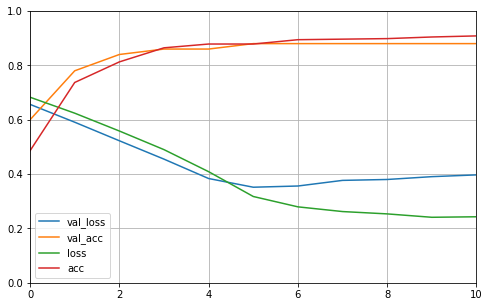

In [15]:
best_nn_history = best_nn.history
pd.DataFrame(best_nn_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# SVM

In [16]:
from sklearn.svm import SVC

In [17]:
"Searching in the poly kernel space"
# use a full grid over all parameters
param_grid = {"degree": range(1, 10, 2),
              "coef0": [0.1, 1.0, 10.0],
              "C": range(1, 10, 1)
             }

svm = SVC(kernel="poly", gamma='auto')
# run grid search
svm_grid_search = GridSearchCV(svm, 
                               param_grid=param_grid, 
                               cv=5, 
                               iid=False, 
                               return_train_score=True)
start = time()
svm_grid_search.fit(Xtr, Ytr.flat)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(svm_grid_search.cv_results_['params'])))
report(svm_grid_search.cv_results_)

GridSearchCV took 47.84 seconds for 135 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.879 (std: 0.023)
Parameters: {'C': 3, 'coef0': 0.1, 'degree': 3}

Model with rank: 2
Mean validation score: 0.875 (std: 0.027)
Parameters: {'C': 5, 'coef0': 0.1, 'degree': 3}

Model with rank: 3
Mean validation score: 0.875 (std: 0.024)
Parameters: {'C': 5, 'coef0': 1.0, 'degree': 3}



In [18]:
best_poly_svm = svm_grid_search.best_estimator_

Ypr = best_poly_svm.predict(Xts)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

Accuracy is  81.15942028985508


In [19]:
"Searching in the rbf kernel space"
# use a full grid over all parameters
param_grid = {"gamma": range(1, 10, 1),
              "coef0": [0.001, 0.01, 0.01, 1, 10, 100, 1000],
              "C": [0.001, 0.01, 0.01, 1, 10, 100, 1000]
             }

svm = SVC(kernel="rbf")
# run grid search
svm_rbf_grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, iid=False, return_train_score=True)
start = time()
svm_rbf_grid_search.fit(Xtr, Ytr.flat)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(svm_rbf_grid_search.cv_results_['params'])))
report(svm_rbf_grid_search.cv_results_)

GridSearchCV took 150.09 seconds for 441 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.735 (std: 0.041)
Parameters: {'C': 100, 'coef0': 0.001, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.735 (std: 0.041)
Parameters: {'C': 100, 'coef0': 0.01, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.735 (std: 0.041)
Parameters: {'C': 100, 'coef0': 0.01, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.735 (std: 0.041)
Parameters: {'C': 100, 'coef0': 1, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.735 (std: 0.041)
Parameters: {'C': 100, 'coef0': 10, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.735 (std: 0.041)
Parameters: {'C': 100, 'coef0': 100, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.735 (std: 0.041)
Parameters: {'C': 100, 'coef0': 1000, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.735 (std: 0.041)
Parameters: {'C': 1000, 'coef0': 0.001, 'gamma': 1}

Model with rank: 1
Mean validation s

In [20]:
best_rbf_svm = svm_rbf_grid_search.best_estimator_
Ypr = best_rbf_svm.predict(Xts)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

Accuracy is  76.81159420289855


# Nearest neighbors


In [21]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1, 25),
              "weights": ['uniform', "distance"],
              "p": [1, 2, 3]
             }

knn = KNeighborsClassifier()
# run grid search
knn_grid_search = GridSearchCV(knn, 
                           param_grid=param_grid, 
                           cv=5, 
                           iid=False, 
                           return_train_score=True)
start = time()
knn_grid_search.fit(Xtr, Ytr.flat)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(knn_grid_search.cv_results_['params'])))
report(knn_grid_search.cv_results_)

GridSearchCV took 93.67 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.884 (std: 0.009)
Parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.875 (std: 0.024)
Parameters: {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}

Model with rank: 3
Mean validation score: 0.875 (std: 0.029)
Parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}



In [22]:
best_knn = knn_grid_search.best_estimator_
Ypr = best_knn.predict(Xts)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

Accuracy is  84.78260869565217


# Boosting 

In [25]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {'learning_rate': [0.1, 0.3, 0.7, 0.9, 1.0, 3.0],
              "n_estimators": [10, 40, 70, 120, 180, 250, 400],
             }

bdt = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None)
# run grid search
bdt_grid_search = GridSearchCV(bdt, 
                           param_grid=param_grid, 
                           cv=5, 
                           iid=False, 
                           return_train_score=True)
start = time()
bdt_grid_search.fit(Xtr, Ytr.flat)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(bdt_grid_search.cv_results_['params'])))

report(bdt_grid_search.cv_results_)

GridSearchCV took 38.24 seconds for 42 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.871 (std: 0.025)
Parameters: {'learning_rate': 0.1, 'n_estimators': 70}

Model with rank: 2
Mean validation score: 0.871 (std: 0.028)
Parameters: {'learning_rate': 0.1, 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.871 (std: 0.028)
Parameters: {'learning_rate': 0.3, 'n_estimators': 10}



In [26]:
best_bdt = bdt_grid_search.best_estimator_
Ypr = best_bdt.predict(Xts)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

Accuracy is  80.43478260869566


In [28]:
from keras.models import model_from_json
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras.utils import CustomObjectScope

def save_neural_network_model(model, name):
    # serialize model to JSON
    model_json = model.to_json()
    model_name = MODEL_DIR + DATASET_NAME + "-" + name
    with open(model_name + "-model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + "-weights.h5")
    history = model.history.history
    with open(model_name + "-history", 'wb') as file_pi:
        pickle.dump(history, file_pi)
        
def load_neural_network(model_name):
    model_name = "neural_network"
    with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        json_file = open(MODEL_DIR + DATASET_NAME + "-" + model_name + "-model.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)

        # load weights into new model
        loaded_model.load_weights(MODEL_DIR + DATASET_NAME + "-" + model_name + "-weights.h5")
        print("Loaded model from disk")

    #Load history
    with open(MODEL_DIR + DATASET_NAME + "-" + model_name + "-history", 'rb') as fid:
        loaded_history = pickle.load(fid)
        
    return loaded_model, loaded_history

In [27]:
import pickle

MODEL_DIR ="models/"
DATASET_NAME = "credit"

best_nn_estimator = rnd_search_cv.best_estimator_
estimators =[('decision_tree', best_dec_tree),
             #('neural_network', best_nn_estimator.model), 
             ('k-nearest-neighbor', best_knn), 
             ('SVM', best_poly_svm),
             ('ada-boost-classifier', best_bdt),
            ]

# save the classifier
for model_name, estimator in estimators:
    
    file_name = MODEL_DIR + DATASET_NAME + "-" + model_name + ".pkl"
    print(file_name)
    
    with open(file_name, 'wb') as fid:
        pickle.dump(estimator, fid)


models/credit-decision_tree.pkl
models/credit-k-nearest-neighbor.pkl
models/credit-SVM.pkl
models/credit-ada-boost-classifier.pkl


In [29]:
save_neural_network_model(best_nn_estimator.model, "neural_network")

In [30]:
# loading the classifier
estimators =[('decision_tree', 0),
             #('neural_network', best_nn_estimator.model), 
             ('k-nearest-neighbor', 0), 
             ('SVM', 0),
             ('ada-boost-classifier', 0),
            ]
models = []


for model_name, estimator in estimators:
    
    file_name = MODEL_DIR + DATASET_NAME + "-" + model_name + ".pkl"
    print(file_name)
    
    with open(file_name, 'rb') as fid:
        model_loaded = pickle.load(fid)
    
    Ypr = model_loaded.predict(Xts)
    print(model_name, accuracy_score(Yts,Ypr)*100) 
    models.append((model_name, model_loaded))

models/credit-decision_tree.pkl
decision_tree 76.81159420289855
models/credit-k-nearest-neighbor.pkl
k-nearest-neighbor 84.78260869565217
models/credit-SVM.pkl
SVM 81.15942028985508
models/credit-ada-boost-classifier.pkl
ada-boost-classifier 80.43478260869566


In [31]:
nn, his = load_neural_network("neural_network")
nn_history = his
models.append(("neural_network", nn))

Ypr = nn.predict(Xts)
Ypr = (Ypr > 0.5)
print("neural_network", accuracy_score(Yts,Ypr)*100)

Loaded model from disk
neural_network 83.33333333333334


In [43]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 13)                676       
_________________________________________________________________
dense_151 (Dense)            (None, 13)                182       
_________________________________________________________________
dense_152 (Dense)            (None, 13)                182       
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 14        
Total params: 1,054
Trainable params: 1,054
Non-trainable params: 0
_________________________________________________________________
